# Проект "Промышленность. Прогнозирование температуры плавления стали"

Условие задачи. 
<br>Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Критерий оценки проекта.
<br>Целевой признак: последняя измеренная  температура
<br>Метрика: MAE
<br>Критерий оцeнки: MAE <6.0 (6sp)



Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Описание данных
<br>Данные состоят из файлов, полученных из разных источников:

<br>data_arc.csv — данные об электродах;
<br>data_bulk.csv — данные о подаче сыпучих материалов (объём);
<br>data_bulk_time.csv — данные о подаче сыпучих материалов (время);
<br>data_gas.csv — данные о продувке сплава газом;
<br>data_temp.csv — результаты измерения температуры;
<br>data_wire.csv — данные о проволочных материалах (объём);
<br>data_wire_time.csv — данные о проволочных материалах (время).

<br>Во всех файлах столбец key содержит номер партии. 
<br>В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

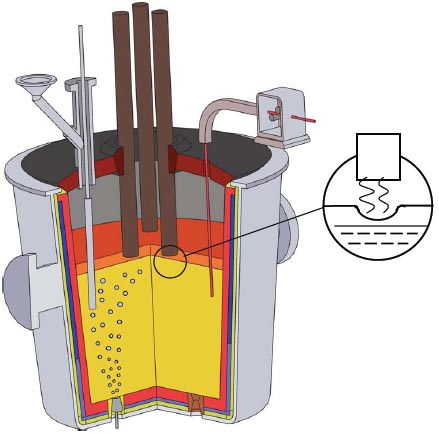

### План работы: ###

<br>1. Изучение данных: открытие файлов, добавление библиотек.

<br>2. Подготовка данных: правка типов данных, работа с 
выбросами, заполнение пропусков, переименование названий столбцов и тп

<br>3. Выделение признаков: в тч целевого. Проведение train_test_split.

<br>4. Выбор моделей для обучения. Несколько моделей регрессии обучить на трейне: CatBoostRegressor, Gradient Boosting, LinearRegression, RandomForestRegressor.

<br>5. Предсказание моделей на тесте и выводы.

### Открытие и изучение файла ###

In [2]:
# Загрузка библиотек
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter('ignore')

In [3]:
# Путь к файлам
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv') # об электродах
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv') # о подаче сыпучих материалов(объем)
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv') # о подаче сыпучих материалов(время)
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv') # о продувке сплава газом
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv') # результаты измерения температуры
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv') # о проволочных материалах(объем)
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv') # о проволочных материалах(время)

После изучения процесса плавки металла в аппарате ковш-печь и загрузки данных из всех таблиц переходим к обработке данных.

### Предобработка данных ###

Рассмотрим каждую таблицу с данными: анализ-выводы.

#### Данные об электродах ####

In [4]:
# Чтение df
data_arc.head(3) 

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805


In [5]:
# Проверка типов данных
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
# Номера партий (строки с повторяющимися значениями)
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
322     13
        ..
614      1
1914     1
2025     1
2795     1
1568     1
Name: key, Length: 3214, dtype: int64

In [7]:
# Min-max по столбцам (период 4 месяца)
data_arc['Начало нагрева дугой'].min(), data_arc['Начало нагрева дугой'].max()

('2019-05-03 11:02:14', '2019-09-01 04:34:47')

In [8]:
data_arc['Конец нагрева дугой'].min(), data_arc['Конец нагрева дугой'].max()

('2019-05-03 11:06:02', '2019-09-01 04:36:08')

Text(0.5, 1.0, 'Распределение по признаку "Активная мощность"')

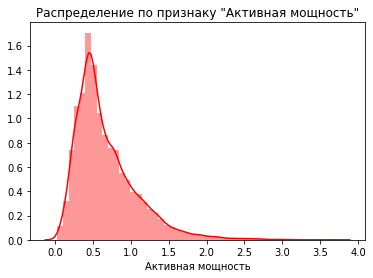

In [9]:
# График по признаку 'Активная мощность'
sns.distplot(data_arc['Активная мощность'], color='red')
plt.title('Распределение по признаку "Активная мощность"')

In [10]:
# Статистические величины по признаку
data_arc['Активная мощность'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: Активная мощность, dtype: float64

Text(0.5, 1.0, 'Распределение по признаку "Реактивная мощность"')

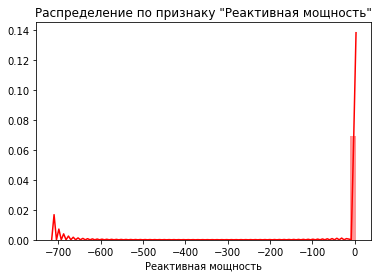

In [11]:
# График по признаку 'Реактивная мощность'
sns.distplot(data_arc['Реактивная мощность'], color='red')
plt.title('Распределение по признаку "Реактивная мощность"')

In [12]:
# Статистические величины по признаку
data_arc['Реактивная мощность'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: Реактивная мощность, dtype: float64

In [13]:
# Количество партий 
data_arc['Реактивная мощность'].sort_values(ascending=False)

7799       2.676388
9226       2.504206
9361       2.459959
12424      2.397032
13760      2.335088
            ...    
4633       0.022983
4914       0.022485
2419       0.021154
5596       0.020806
9780    -715.504924
Name: Реактивная мощность, Length: 14876, dtype: float64

Без выявленной строки распределение становится ближе к нормальному, следовательно целесообразно заменить значение на медиану 0.415984.

In [14]:
data_arc_drop_9780 = data_arc.drop(index=[9780])

In [15]:
data_arc_drop_9780['Реактивная мощность'].describe()

count    14875.000000
mean         0.500723
std          0.310880
min          0.020806
25%          0.291003
50%          0.415984
75%          0.637403
max          2.676388
Name: Реактивная мощность, dtype: float64

In [16]:
# Замена отрицательного значения на медиану
data_arc.loc[data_arc["Реактивная мощность"] < 0, "Реактивная мощность"] = \
    data_arc.loc[data_arc["Реактивная мощность"] >= 0, "Реактивная мощность"].median()

Text(0.5, 1.0, 'Распределение по признаку "Реактивная мощность"')

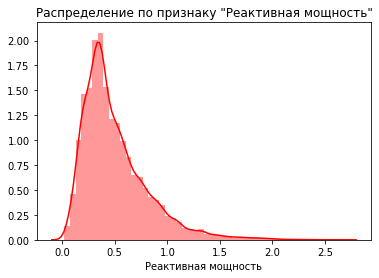

In [17]:
sns.distplot(data_arc['Реактивная мощность'], color='red')
plt.title('Распределение по признаку "Реактивная мощность"')

In [18]:
data_arc['working_time'] = ((pd.to_datetime(data_arc['Конец нагрева дугой']) - 
                            pd.to_datetime(data_arc['Начало нагрева дугой']))
                                .astype('<m8[m]').astype(int))
print (data_arc)

        key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0         1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1         1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2         1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3         1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4         1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   
...     ...                  ...                  ...                ...   
14871  3241  2019-09-01 03:58:58  2019-09-01 04:01:35           0.533670   
14872  3241  2019-09-01 04:05:04  2019-09-01 04:08:04           0.676604   
14873  3241  2019-09-01 04:16:41  2019-09-01 04:19:45           0.733899   
14874  3241  2019-09-01 04:31:51  2019-09-01 04:32:48           0.220694   
14875  3241  2019-09-01 04:34:47  2019-09-01 04:36:08           0.306580   

       Реактивная мощность  working_time  
0                 0.687084             3  
1

In [19]:
data_arc['working_time'].describe()

count    14876.000000
mean         2.425988
std          1.660323
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         15.000000
Name: working_time, dtype: float64

##### Выводы:
Данные без пропусков, за 4 месяца: май-сентябрь 2019, здесь и в последующих таблицах даты с типом данных не datetime, время работы электродов (working_time) составляет в среднем 2 минуты (не больше 15 минут); в признаке  'Реактивная мощность' выявлено отрицательное значение (-716) и заменено на медиану, распределение признаков 'Активная мощность' и 'Реактивная мощность' имеют нормальное распределение со смещением влево.
<br>Как указано в задании здесь и далее наблюдается несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

#### Данные о подаче сыпучих материалов(объем) ####

In [20]:
data_bulk.head(3) 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


In [21]:
data_bulk['Bulk 1'].unique()

array([ nan,  46.,  27.,  48.,  29.,  78.,  52.,  69.,  51.,  73.,  92.,
        65.,  75.,  94., 185.,  67.,  37.,  10.,  43.,  34.,  54.,  44.,
        39.,  90.,  62.,  60.,  31.,  33.,  50.,  83.,  58.,  41.,  38.,
        30.,  63.,  19.,  21.,  47., 118.,  28.,  36.,  22.,  32.,  24.,
       104.,  74.,  26.,  16.])

In [22]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [23]:
# Проверка выборки на предмет пропусков
data_bulk.isna().sum() 

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [24]:
# Процент пропусков по каждому признаку
print(round((data_bulk.isnull().sum() * 100/ len(data_bulk)),2).sort_values(ascending=False))

Bulk 8     99.97
Bulk 13    99.42
Bulk 9     99.39
Bulk 2     99.30
Bulk 7     99.20
Bulk 5     97.54
Bulk 10    94.38
Bulk 11    94.34
Bulk 1     91.95
Bulk 6     81.59
Bulk 4     67.59
Bulk 3     58.52
Bulk 15    28.16
Bulk 12    21.70
Bulk 14    10.32
key         0.00
dtype: float64


In [25]:
data_bulk['key'].value_counts()

2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

Text(0.5, 0.9, 'Распределение значений подачи сыпучих материалов (по объему)')

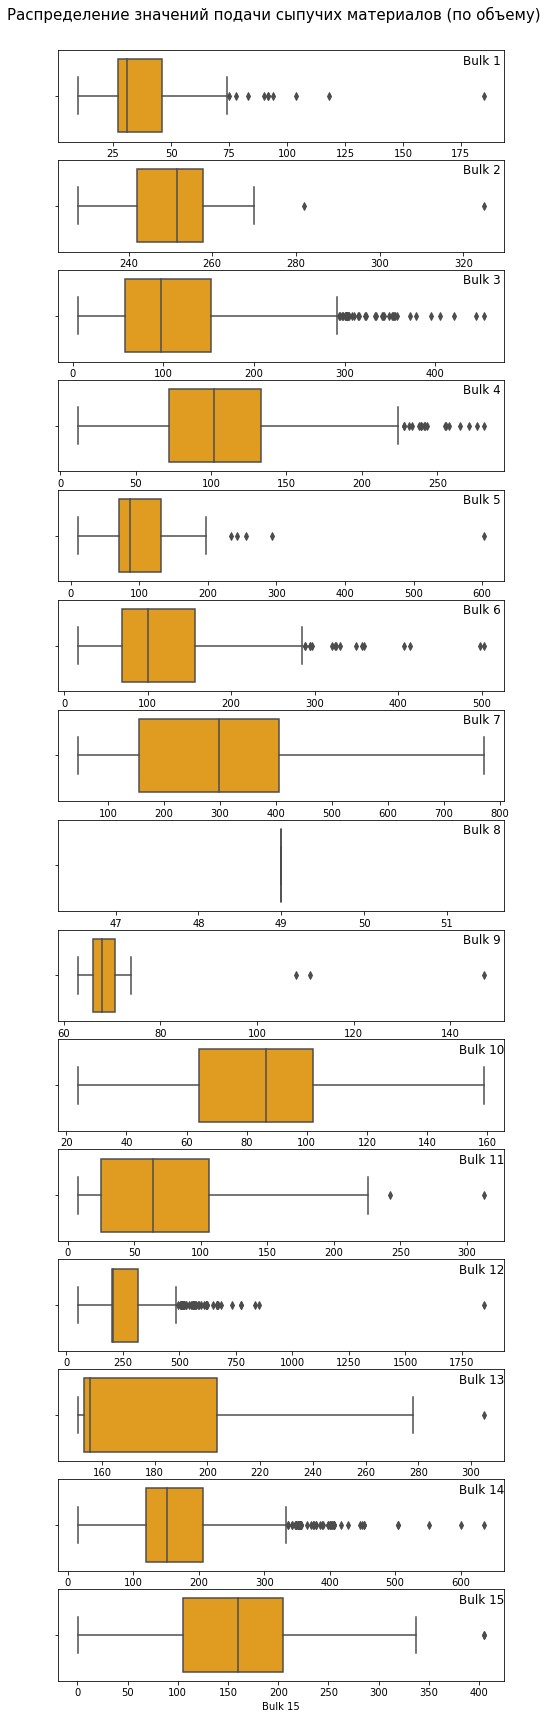

In [26]:
#Boxplot по каждому значению подачи сыпучих материалов
fig, axes = plt.subplots(15,1, figsize=(8,30))

for i, j in zip(data_bulk.columns[1:], range(data_bulk.shape[1]+1)):
                    sns.boxplot(data_bulk[i], color='orange', ax=axes[j])
                    axes[j].set_title(i, x=0.95, y=0.78, size=12)

plt.suptitle('Распределение значений подачи сыпучих материалов (по объему)', size=15, y=0.9)

##### Выводы:
Каждый признак таблицы 'Данные о подаче сыпучих материалов(объем)' содержит пропуски 10-100% (до 99.97%- 8 этап из 15) - является нормой технологического процесса.
<br>При рассмотрении каждого признака в boxplot имеются выбросы- также некорректно удалять- логика этапов технологического процесса.

#### Данные о подаче сыпучих материалов(время) ####

In [27]:
data_bulk_time.head(3) 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40


In [28]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [29]:
data_bulk_time.isna().sum() 

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [30]:
print(round((data_bulk_time.isnull().sum() * 100/ len(data_bulk_time)),2).sort_values(ascending=False))

Bulk 8     99.97
Bulk 13    99.42
Bulk 9     99.39
Bulk 2     99.30
Bulk 7     99.20
Bulk 5     97.54
Bulk 10    94.38
Bulk 11    94.34
Bulk 1     91.95
Bulk 6     81.59
Bulk 4     67.59
Bulk 3     58.52
Bulk 15    28.16
Bulk 12    21.70
Bulk 14    10.32
key         0.00
dtype: float64


In [31]:
data_bulk_time['key'].value_counts()

2047    1
1070    1
1092    1
3139    1
1090    1
       ..
2590    1
541     1
2588    1
539     1
2049    1
Name: key, Length: 3129, dtype: int64

##### Выводы:
Картина данных выборки аналогичная предыдущему подразделу.

#### Данные о продувке сплава газом ####

In [32]:
data_gas.head(3) 

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [33]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [34]:
data_gas['key'].value_counts()

2047    1
2580    1
2600    1
549     1
2596    1
       ..
3119    1
1070    1
3115    1
1066    1
2049    1
Name: key, Length: 3239, dtype: int64

In [35]:
data_gas['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Text(0.5, 1.0, 'Распределение по признаку "Газ 1"')

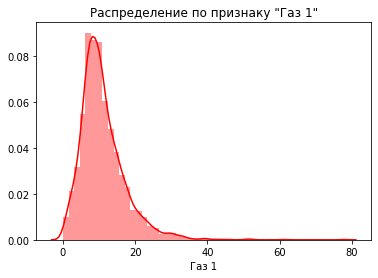

In [36]:
sns.distplot(data_gas['Газ 1'], color='red')
plt.title('Распределение по признаку "Газ 1"')

##### Выводы:
Выборка 'Данные о продувке сплава газом' без пропусков, гистограмма показывает их нормальное распределение с отклонение влево; выбросы присутствуют- при медиане не более 10, максимум составляет 78.

#### Результаты измерения температуры ####

In [37]:
data_temp.head(3) 

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


In [38]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [39]:
data_temp.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

In [40]:
data_temp['key'].value_counts()

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

In [41]:
data_temp['Время замера'].min(), data_temp['Время замера'].max()

('2019-05-03 11:16:18', '2019-09-01 04:38:08')

In [42]:
data_temp['Температура'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

Text(0.5, 1, 'Распределение результатов измерения температуры')

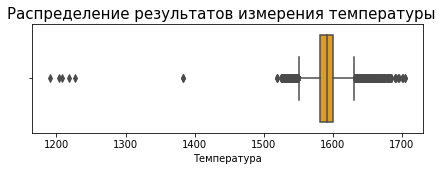

In [43]:
fig, axes = plt.subplots(figsize=(7,2))
sns.boxplot(x='Температура', data=data_temp, color='orange')
plt.suptitle('Распределение результатов измерения температуры', size=15, y=1)

##### Выводы:
Пропуски в данных только по признаку 'Температура'(18% данных) диапазон рабочих температур составляет 1191-1705 С при среднем значении 1591 С - особенность технологического процесса, период выборки аналогичен предыдущим таблицам для целей сопоставимости в дальнейшей обработке; boxplot показывает выбросы- все что выше 1590 С (температура металла в ковше во время процесса производства- технология).

#### Данные о проволочных материалах(объем) ####

In [44]:
data_wire.head(3) 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [46]:
data_wire['key'].value_counts()

2047    1
1022    1
1092    1
3139    1
1090    1
       ..
2592    1
543     1
2590    1
541     1
2049    1
Name: key, Length: 3081, dtype: int64

In [47]:
print(round((data_wire.isnull().sum() * 100/ len(data_wire)),2).sort_values(ascending=False))

Wire 5    99.97
Wire 7    99.64
Wire 4    99.55
Wire 8    99.38
Wire 9    99.06
Wire 3    97.96
Wire 6    97.63
Wire 2    64.98
Wire 1     0.84
key        0.00
dtype: float64


Text(0.5, 0.9, 'Распределение значений проволочных материалов(по объему)')

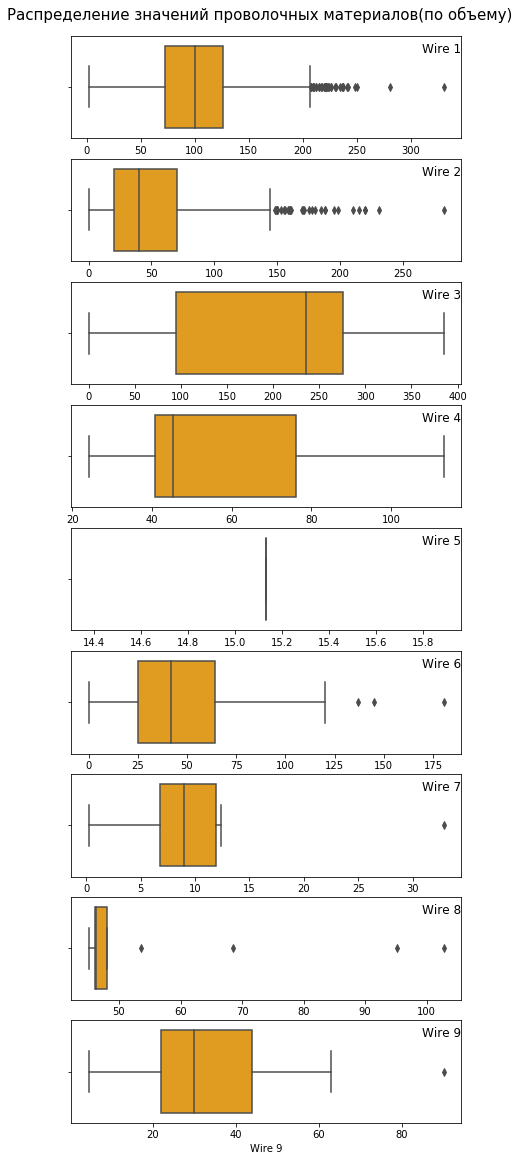

In [48]:
fig, axes = plt.subplots(9,1, figsize=(7,20))

for i, j in zip(data_wire.columns[1:], range(data_wire.shape[1]+1)):
                    sns.boxplot(data_wire[i], color='orange', ax=axes[j])
                    axes[j].set_title(i, x=0.95, y=0.78, size=12)

plt.suptitle('Распределение значений проволочных материалов(по объему)', size=15, y=0.9)

##### Выводы: 
Данные с пропусками и выбросами. Используется проволока Wire 1- остальные крайне редко (по ним пропусков 65-100%).

#### Данные о проволочных материалах(время) ####

In [49]:
data_wire_time.head(3) 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [51]:
data_wire_time.isna().sum() 

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [52]:
print(round((data_wire_time.isnull().sum() * 100/ len(data_wire_time)),2).sort_values(ascending=False))

Wire 5    99.97
Wire 7    99.64
Wire 4    99.55
Wire 8    99.38
Wire 9    99.06
Wire 3    97.96
Wire 6    97.63
Wire 2    64.98
Wire 1     0.84
key        0.00
dtype: float64


In [53]:
data_wire_time['key'].value_counts()

2047    1
1022    1
1092    1
3139    1
1090    1
       ..
2592    1
543     1
2590    1
541     1
2049    1
Name: key, Length: 3081, dtype: int64

##### Выводы:
Картина данных выборки аналогичная предыдущему подразделу.

При исследовании предоставленных данных выведен ряд технологических закономерностей; изучены и прокомментированы данные, пропуски, гистограммы и boxplot-ы с распределением и выбросами.
<br>Добавлены 2 раздела: План работ (в начале) и Вопросы для тимлида.

### Вопросы: ###

<br>1. data_arc['Реактивная мощность'] значение по строке 9780: -716: удалить некорректно, заменить медианой или наиболее часто встречающимся значением?

<br>2. До 15мин. нагрев электородов норма? при средних - 2мин.
Используются даты для предсказания или удаляем?

<br>3. Каждый признак таблицы 'Данные о подаче сыпучих материалов(объем)' содержит пропуски 10-100% (до 99.97%) - является нормой технологического процесса?

<br>4.Таблица 'Результаты измерения температуры' по признаку 'Температура'- все что выше 1590 С (температура металла в ковше во время процесса производства по нормам- технология) не удаляем?, что это означает на практике?- сбой или реальная работа технологии.

<br>5. Таблица 'Данные о проволочных материалах(объем)'- почему используется только проволока Wire 1, зачем все остальные виды включают при малом их использовании?

### Обработка данных

Данные об электродах: data_arc 
<br>Данные о подаче сыпучих материалов(объем): data_bulk
<br>Данные о подаче сыпучих материалов(время): data_bulk_time
<br>Данные о продувке сплава газом: data_gas 
<br>Результаты измерения температуры: data_temp 
<br>Данные о проволочных материалах(объем): data_wire
<br>Данные о проволочных материалах(время): data_wire_time




Для дальнейшей обработки данных необходимо обратить внимание на ряд моментов:
<br>- разнотипные названия столбцов в таблицах- указать английским в нижнем регистре без пробелов;
<br>- несоответствие по типу данных- далее заменить Bulk и Wire в таблицах (+ NaN на 0) на int;
<br>- перевод признаков с временем в формат datetime;

<br>- правка аномального значения (-716) реактивной мощности в таблице data_arc произведена в предыдущем разделе.

Для начала проведу замену названия столбцов таблиц 'data_arc', 'data_gas', 'data_temp' на единый формат.

In [54]:
# Переименование столбцов таблиц
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'warming_start', 'Конец нагрева дугой':'warming_end', 
                                    'Активная мощность':'active_power','Реактивная мощность':'reactive_power',})
data_arc.head(3)

,key,warming_start,warming_end,active_power,reactive_power,working_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,3
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,3
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2


In [55]:
data_gas = data_gas.rename(columns={'Газ 1':'gas_amount'})
data_gas.head(3)

,key,gas_amount
0,1,29.749986
1,2,12.555561
2,3,28.554793


In [56]:
data_temp = data_temp.rename(columns={'Время замера':'time', 'Температура':'temp'})
data_temp.head(3)

,key,time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


Далее замена типа данных дат на int и datetime.

In [57]:
# Замена типа данных на int
def int(data, column):
    
    data[column] = pd.to_datetime(data[column]).astype('int64')      

In [58]:
for i in data_bulk_time.columns[1:]:
    int(data_bulk_time, i)

In [59]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key     15907 non-null int64
time    15907 non-null object
temp    13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [60]:
# Замена типа данных по датам
def datetime(data, column):
    
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%dT%H:%M:%S')

In [61]:
datetime(data_arc, 'warming_start')
datetime(data_arc, 'warming_end')
datetime(data_temp, 'time')

for i in data_bulk_time.columns[1:]:
    datetime(data_bulk_time, i)
    
for i in data_wire_time.columns[1:]:
    datetime(data_wire_time, i)    

In [62]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
key               14876 non-null int64
warming_start     14876 non-null datetime64[ns]
warming_end       14876 non-null datetime64[ns]
active_power      14876 non-null float64
reactive_power    14876 non-null float64
working_time      14876 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 697.4 KB


In [63]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Наименование столбцов и типы данных корректны, далее необходимо собрать таблицу с фичами для обучения модели и предсказания температуру стали.

<br>Перечень действий:
<br>-считаем полную мощность из активной и реактивной;
<br>-получаем суммарные значения по добавкам: Bulk и Wire;
<br>-оставляем только строки с key в таблице 'data_temp', где есть первичная/ конечная температура, а остальные удаляем.

##### Расчет полной мощности

Полную мощность 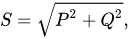 считаем из таблицы 'data_arc' и оставляем соответствующие признаки для обучения модели.

In [64]:
# Добавление признака 'Полная мощность'(Активная+Реактивная)
data_arc['full_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2) 
data_arc.head(3)

,key,warming_start,warming_end,active_power,reactive_power,working_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,3,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,3,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2,0.896038


In [65]:
# Группировка по 'key'
data_arc_2 = data_arc.groupby('key')['full_power', 'active_power','reactive_power'].sum()
data_arc_2.head(3)

,full_power,active_power,reactive_power
key,,,
1,5.826395,4.878147,3.183241
2,3.649216,3.052598,1.998112
3,2.989534,2.525882,1.599076


##### Расчет суммарной добавки сухих веществ

Добавки (Bulk1-Bulk15) допустимо просуммировать; NaN заменим на '0'; Bulk 14 подается в печь-ковш, остальные крайне редко.

In [66]:
# Замена NaN на '0' и расчет суммарного Bulk
data_bulk= data_bulk.fillna(0)

data_bulk['bulk_full'] = (data_bulk['Bulk 1'] + data_bulk['Bulk 2'] + data_bulk['Bulk 3'] + data_bulk['Bulk 4'] +
                        data_bulk['Bulk 5'] + data_bulk['Bulk 6'] + data_bulk['Bulk 7'] + data_bulk['Bulk 8'] +
                        data_bulk['Bulk 9'] + data_bulk['Bulk 10'] + data_bulk['Bulk 11'] + data_bulk['Bulk 12'] + 
                        data_bulk['Bulk 13'] + data_bulk['Bulk 14'] + data_bulk['Bulk 15'])
data_bulk.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_full
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>ок, заменяем на 0

In [67]:
#Сохранение необходимых признаков
data_bulk_2 = data_bulk[['key','bulk_full']]
data_bulk_2.head(3)

,key,bulk_full
0,1,553.0
1,2,582.0
2,3,544.0


##### Расчет суммарной добавки проволоки

Проводим обработку аналогичную предыдущему разделу.

In [68]:
# Замена NaN на '0' и расчет суммарного Wire
data_wire = data_wire.fillna(0)

data_wire['wire_full'] = (data_wire['Wire 1'] + data_wire['Wire 2'] + data_wire['Wire 3'] + data_wire['Wire 4'] +
                        data_wire['Wire 5'] + data_wire['Wire 6'] + data_wire['Wire 7'] + data_wire['Wire 8'] + 
                        data_wire['Wire 9'])
data_wire.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_full
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157


In [69]:
#Сохранение необходимых признаков
data_wire_2 = data_wire[['key','wire_full']]
data_wire_2.head(3)

,key,wire_full
0,1,60.059998
1,2,96.052315
2,3,91.160157


##### Подготовка признака 'Температура'

В финале самая важная составляющая для предсказания температуру стали с целевым признаком, в данных есть NaN.
<br>Оставляем 'key' есть первичная/ конечная температура, а остальные удаляем.

In [70]:
data_temp.tail(3) 

,key,time,temp
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [71]:
data_temp.head(5) 

,key,time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [72]:
# Выборка партий на предмет кол-ва записей по температурам
temp = data_temp.groupby('key')['temp'].count().reset_index()
temp['temp'].value_counts()

1     741
4     650
5     585
3     432
6     370
7     182
8     100
2      56
9      43
10     21
11     16
12     12
16      4
15      2
13      1
14      1
Name: temp, dtype: int64

Удаляем 741 партию с 1 замером и оставляем первую/последнюю температуру каждой партии.

In [73]:
# Выделение значения temp_once (одно значение 'temp')
temp_one = temp.loc[temp['temp'] == 1,'key']
temp_one.head(3)

192      195
276      279
2477    2500
Name: key, dtype: int64

In [74]:
# Удаление партий с одним значением 'temp'
data_temp_drop = data_temp.copy()
data_temp_drop = data_temp_drop.drop(data_temp_drop[data_temp_drop['key'].isin(temp_one.values)].index)

data_temp_drop.head(3)

,key,time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


In [75]:
# Цикл для определения условия (первая/ последняя температура) по ключу
keys = data_temp_drop['key'].unique()

temp_first_final = pd.DataFrame(columns=['key','temp_first', 'temp_final'])

i = 0
for key in keys:
    
    row = data_temp_drop.query('key == @key').reset_index()
    first = row['temp'].tolist()[0]
    final = row['temp'].tolist()[-1]
    
    temp_first_final.loc[i, 'key'] = key
    temp_first_final.loc[i, 'temp_first'] = first
    temp_first_final.loc[i, 'temp_final'] = final
    
    i += 1
    
temp_first_final.head(3)    

,key,temp_first,temp_final
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599


In [76]:
# Замена типа данных на 'int'
temp_first_final['temp_first'] = temp_first_final['temp_first'].astype('int64')
temp_first_final['temp_final'] = temp_first_final['temp_final'].astype('int64')

In [77]:
# Проверка наличия пропусков
temp_first_final.isna().sum()

key           0
temp_first    0
temp_final    0
dtype: int64

'temp_final' - определен целевой признак.

##### Вывод:
Проведена дообработка признаков, получен набор таблиц для дальнейшего объединения для обучения модели и выделен целевой признак.

### Выбор признаков и объединение таблиц 

Объединяем все подготовленные таблицы из предыдущего раздела.

In [78]:
# Добавление таблицы temp_start_end (начало/конец измерения 'temp')
data_all = temp_first_final.copy()
data_all.head(3)

,key,temp_first,temp_final
0,1,1571,1613
1,2,1581,1602
2,3,1596,1599


In [79]:
# Объединение с таблицей 'data_arc_2' (полная мощность)
data_all = data_all.merge(data_arc_2, on='key')
data_all.head(3)

,key,temp_first,temp_final,full_power,active_power,reactive_power
0,1,1571,1613,5.826395,4.878147,3.183241
1,2,1581,1602,3.649216,3.052598,1.998112
2,3,1596,1599,2.989534,2.525882,1.599076


In [80]:
# Объединение с таблицей 'data_bulk_2' (объем сыпучих добавок)
data_all = data_all.merge(data_bulk_2, on='key')
data_all.head(3)

,key,temp_first,temp_final,full_power,active_power,reactive_power,bulk_full
0,1,1571,1613,5.826395,4.878147,3.183241,553.0
1,2,1581,1602,3.649216,3.052598,1.998112,582.0
2,3,1596,1599,2.989534,2.525882,1.599076,544.0


In [81]:
# Объединение с таблицей 'data_wire_2' (количество проволоки)
data_all = data_all.merge(data_wire_2, on='key')
data_all.head(3)

,key,temp_first,temp_final,full_power,active_power,reactive_power,bulk_full,wire_full
0,1,1571,1613,5.826395,4.878147,3.183241,553.0,60.059998
1,2,1581,1602,3.649216,3.052598,1.998112,582.0,96.052315
2,3,1596,1599,2.989534,2.525882,1.599076,544.0,91.160157


In [82]:
# Объединение с таблицей 'data_gas' (количество инертного газа)
data_all = data_all.merge(data_gas, on='key')
data_all.head(3)

,key,temp_first,temp_final,full_power,active_power,reactive_power,bulk_full,wire_full,gas_amount
0,1,1571,1613,5.826395,4.878147,3.183241,553.0,60.059998,29.749986
1,2,1581,1602,3.649216,3.052598,1.998112,582.0,96.052315,12.555561
2,3,1596,1599,2.989534,2.525882,1.599076,544.0,91.160157,28.554793


In [83]:
# Исключение 'key' из признаков для обучения моделей
data_all = data_all.drop(['key'], axis=1)
data_all.head(3)

,temp_first,temp_final,full_power,active_power,reactive_power,bulk_full,wire_full,gas_amount
0,1571,1613,5.826395,4.878147,3.183241,553.0,60.059998,29.749986
1,1581,1602,3.649216,3.052598,1.998112,582.0,96.052315,12.555561
2,1596,1599,2.989534,2.525882,1.599076,544.0,91.160157,28.554793


In [84]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 8 columns):
temp_first        2329 non-null int64
temp_final        2329 non-null int64
full_power        2329 non-null float64
active_power      2329 non-null float64
reactive_power    2329 non-null float64
bulk_full         2329 non-null float64
wire_full         2329 non-null float64
gas_amount        2329 non-null float64
dtypes: float64(6), int64(2)
memory usage: 163.8 KB


In [85]:
data_all.describe()

,temp_first,temp_final,full_power,active_power,reactive_power,bulk_full,wire_full,gas_amount
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1586.718763,1593.365393,3.941955,3.152449,2.351247,609.630313,125.208530,11.375600
std,28.290792,11.200915,1.779208,1.425290,1.081603,287.599678,63.683386,6.392041
min,1191.000000,1541.000000,0.257637,0.186226,0.158247,19.000000,1.918800,0.008399
25%,1571.000000,1587.000000,2.735080,2.173277,1.626854,440.000000,89.013596,7.282948
50%,1587.000000,1593.000000,3.773603,3.028334,2.234997,609.000000,116.101440,10.100950
75%,1603.000000,1598.000000,4.892791,3.920676,2.915089,795.000000,151.568558,14.216688
max,1660.000000,1653.000000,21.564771,17.496497,12.587990,3235.000000,568.777664,77.995040


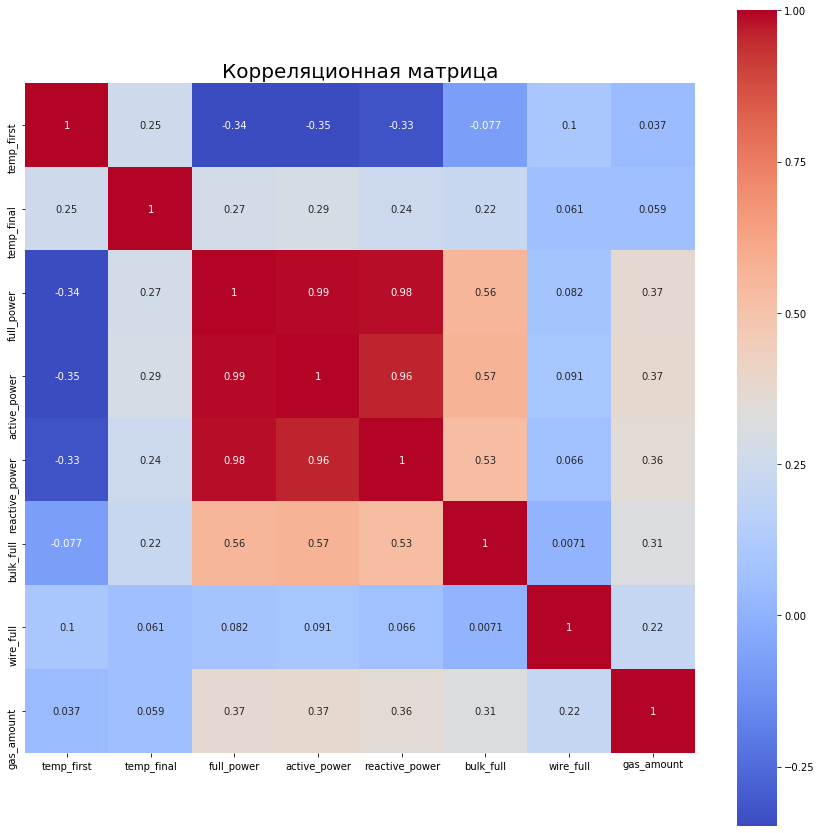

In [86]:
# Корреляционная матрица 'data_all'
corr = data_all.corr()
plt.figure(figsize = (15, 15))
sns.heatmap(corr, vmax = 1, square = True, annot = True, cmap ='coolwarm', fmt='.2g')
plt.title('Корреляционная матрица', size = 20)
plt.show()

По тепловой карте заметно коррелируют мощности из таблицы 'data_arc_2'- допустимо оставить только 'full_power'.

In [87]:
# Исключение коррелирующих признаков
data_all = data_all.drop(['active_power', 'reactive_power'], axis=1)
data_all.head(3)

,temp_first,temp_final,full_power,bulk_full,wire_full,gas_amount
0,1571,1613,5.826395,553.0,60.059998,29.749986
1,1581,1602,3.649216,582.0,96.052315,12.555561
2,1596,1599,2.989534,544.0,91.160157,28.554793


##### Выводы:
Объединены все подготовленные таблицы для обучения; по тепловой карте выявлены коррелирующие признаки: удалены признаки 'active_power' и 'reactive_power'.

### Машинное обучение

Для начала разобъем выборки на обучающую/ тестовую.
<br> Для обучения и получения предсказания температуры стали применим 4 модели: CatBoostRegressor, Gradient Boosting, LinearRegression, RandomForestRegressor.
<br>Проверим предсказания на тесте.

In [88]:
# Отделение 20% данных для тестовой выборки, на обучающую- 80%
features = data_all.drop('temp_final', axis=1)
target = data_all['temp_final']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.2, 
                                                            random_state=12345)

##### CatBoostRegressor

In [89]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=12345)
MAE_cb = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE of CatBoostRegressor = {0:.2f}'.format( MAE_cb))

MAE of CatBoostRegressor = 6.57
CPU times: user 36.5 s, sys: 3.86 s, total: 40.3 s
Wall time: 45.6 s


In [90]:
%%time
#Обучение модели
model_cb = CatBoostRegressor()
model_cb.fit(features_train, target_train)

0:	learn: 11.1266091	total: 1.27ms	remaining: 1.27s
1:	learn: 11.0466316	total: 2.49ms	remaining: 1.24s
2:	learn: 10.9751903	total: 3.5ms	remaining: 1.16s
3:	learn: 10.8940402	total: 4.42ms	remaining: 1.1s
4:	learn: 10.8258469	total: 5.33ms	remaining: 1.06s
5:	learn: 10.7564742	total: 10.8ms	remaining: 1.8s
6:	learn: 10.6778232	total: 12.6ms	remaining: 1.79s
7:	learn: 10.6076688	total: 14.5ms	remaining: 1.8s
8:	learn: 10.5426807	total: 16.7ms	remaining: 1.84s
9:	learn: 10.4784314	total: 95ms	remaining: 9.4s
10:	learn: 10.4122643	total: 95.9ms	remaining: 8.62s
11:	learn: 10.3528222	total: 97.6ms	remaining: 8.04s
12:	learn: 10.2968535	total: 98.5ms	remaining: 7.48s
13:	learn: 10.2464391	total: 99.4ms	remaining: 7s
14:	learn: 10.1979050	total: 100ms	remaining: 6.58s
15:	learn: 10.1453220	total: 101ms	remaining: 6.22s
16:	learn: 10.0941183	total: 102ms	remaining: 5.9s
17:	learn: 10.0499456	total: 103ms	remaining: 5.61s
18:	learn: 10.0091852	total: 105ms	remaining: 5.43s
19:	learn: 9.966573

In [91]:
%%time
#Предсказание на тестовой выборке
target_predict = model_cb.predict(features_test)

CPU times: user 5.58 ms, sys: 361 µs, total: 5.94 ms
Wall time: 2.2 ms


In [92]:
#MAE на тестовой выборке
test_MAE_cb = mean_absolute_error(target_test, target_predict)
print('test_MAE of CatBoostRegressor = {0:.2f}'.format(test_MAE_cb))

test_MAE of CatBoostRegressor = 6.64


##### GradientBoostingRegressor

In [93]:
%%time

#GradientBoostingRegressor()
regressor = GradientBoostingRegressor() 
hyperparams = [{'n_estimators': range (1, 20, 2), 
                'max_depth': range (1,5),
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.2f for %r"% ((mean*-1), params))

MAE_gb = (max(means)*-1)

{'max_depth': 4, 'n_estimators': 19, 'random_state': 12345}
8.04 for {'max_depth': 1, 'n_estimators': 1, 'random_state': 12345}
7.96 for {'max_depth': 1, 'n_estimators': 3, 'random_state': 12345}
7.87 for {'max_depth': 1, 'n_estimators': 5, 'random_state': 12345}
7.81 for {'max_depth': 1, 'n_estimators': 7, 'random_state': 12345}
7.74 for {'max_depth': 1, 'n_estimators': 9, 'random_state': 12345}
7.68 for {'max_depth': 1, 'n_estimators': 11, 'random_state': 12345}
7.63 for {'max_depth': 1, 'n_estimators': 13, 'random_state': 12345}
7.59 for {'max_depth': 1, 'n_estimators': 15, 'random_state': 12345}
7.54 for {'max_depth': 1, 'n_estimators': 17, 'random_state': 12345}
7.50 for {'max_depth': 1, 'n_estimators': 19, 'random_state': 12345}
7.95 for {'max_depth': 2, 'n_estimators': 1, 'random_state': 12345}
7.74 for {'max_depth': 2, 'n_estimators': 3, 'random_state': 12345}
7.58 for {'max_depth': 2, 'n_estimators': 5, 'random_state': 12345}
7.46 for {'max_depth': 2, 'n_estimators': 7, 'rando

In [94]:
%%time

model = GradientBoostingRegressor(n_estimators=19, 
                      max_depth=4, 
                      random_state=12345)
model.fit(features_train, target_train)

CPU times: user 24.5 ms, sys: 0 ns, total: 24.5 ms
Wall time: 22.9 ms


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=19,
                          n_iter_no_change=None, presort='auto',
                          random_state=12345, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [95]:
%%time

target_predict = model.predict(features_test)

CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.39 ms


In [96]:
test_MAE_gb = mean_absolute_error(target_test, target_predict)
print('test_MAE of GradientBoostingRegressor = {0:.2f}'.format(test_MAE_gb))

test_MAE of GradientBoostingRegressor = 6.87


##### LinearRegression

In [97]:
%%time

#LinearRegression_кросвалидация
regressor = LinearRegression()
MAE_lr = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE of LinearRegression = {0:.2f}'.format(MAE_lr))

MAE of LinearRegression = 6.96
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.1 ms


In [98]:
%%time
#Обучение модели
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 2.32 ms, sys: 0 ns, total: 2.32 ms
Wall time: 1.63 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [99]:
%%time
#Предсказание на тестовой выборке
target_predict = model.predict(features_test)

CPU times: user 0 ns, sys: 857 µs, total: 857 µs
Wall time: 809 µs


In [100]:
#MAE на тестовой выборке
test_MAE_lr = mean_absolute_error(target_test, target_predict)
print('test_MAE of LinearRegression = {0:.2f}'.format(test_MAE_lr))

test_MAE of LinearRegression = 7.22


##### RandomForestRegressor

In [101]:
%%time

#RandomForestRegressor()
regressor = RandomForestRegressor() 
hyperparams =  [{'n_estimators':[x for x in range(10, 101, 20)], 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error')
clf.fit(features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.2f for %r"% ((mean*-1), params))

MAE_rf = (max(means)*-1)

{'n_estimators': 90, 'random_state': 12345}
6.90 for {'n_estimators': 10, 'random_state': 12345}
6.70 for {'n_estimators': 30, 'random_state': 12345}
6.63 for {'n_estimators': 50, 'random_state': 12345}
6.61 for {'n_estimators': 70, 'random_state': 12345}
6.59 for {'n_estimators': 90, 'random_state': 12345}
CPU times: user 3.46 s, sys: 0 ns, total: 3.46 s
Wall time: 3.48 s


In [102]:
%%time

model = RandomForestRegressor(n_estimators=90, 
                      random_state=12345)
model.fit(features_train, target_train)

CPU times: user 502 ms, sys: 0 ns, total: 502 ms
Wall time: 509 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=90,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [103]:
%%time

target_predict = model.predict(features_test)

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 13.5 ms


In [104]:
test_MAE_rf = mean_absolute_error(target_test, target_predict)
print('test_MAE of RandomForestRegressor = {0:.2f}'.format(test_MAE_rf))

test_MAE of RandomForestRegressor = 6.74


In [105]:
# Свод по метрикам
index = ['CatBoostRegressor',
         'LinearRegression',
         'GradientBoostingRegressor',
         'RandomForestRegressor']
data = {'MAE на обучении':[MAE_cb,
                     MAE_lr,
                     MAE_gb,
                     MAE_rf],
        'MAE на тесте':[test_MAE_cb,
                        test_MAE_lr,
                        test_MAE_gb,
                        test_MAE_rf]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE на обучении,MAE на тесте
CatBoostRegressor,6.574872,6.640592
LinearRegression,6.964195,7.216793
GradientBoostingRegressor,6.724280,6.868593
RandomForestRegressor,6.594835,6.738221


Для лучшей модели CatBoostRegressor дополнительно выведена важность факторов с помощью feature_importances_.
<br> Логично наибольший вес (по 30% от общего количества) имеют признаки 'temp_first' и 'full_power'.

In [106]:
# feature_importances_ по features_train модели CatBoostRegressor
importances = model_cb.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head()

,feature,importance
0,temp_first,30.204252
1,full_power,29.732532
2,wire_full,14.010205
3,bulk_full,13.111196
4,gas_amount,12.941815


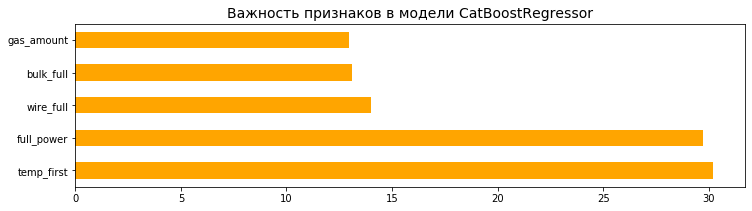

In [107]:
# График feature_importances_
feat_importances = pd.Series(model_cb.feature_importances_, index=features_train.columns)
plt.figure(figsize=(12,3))
feat_importances.nlargest().plot(kind='barh', color='orange')

plt.title('Важность признаков в модели CatBoostRegressor', size=14);

### Вывод:
В рамках обозначенной задачи бизнеса - "предсказание температуры стали" были обучены 4 модели: CatBoostRegressor, Gradient Boosting, LinearRegression, RandomForestRegressor и получены по ним предсказания. 
<br>Проведена разбивка выборок по train_test_split и cross_val_score для определения лучших параметров.
<br>Метрика MAE применялась для оценки каждой модели на обучении и на тесте.
<br> Лучшая метрика у модели CatBoostRegressor	6.6 на тесте и трейне (ошибку модели в 6 градусов допустимо считать приемлимой), остальные модели в диапазонах тест 6.6-7.2 (трейн: 6.6-7.0).

### Итоговый отчет

Перечень вопросов:
<br>1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?
<br>2. Какие трудности возникли и как вы их преодолели?
<br>3. Какие ключевые шаги в решении задачи выделили?
<br>4. Какая ваша итоговая модель и какое у неё качество?

##### Пункты плана проекта:

1. Изучены данные: открытие файлов, добавление библиотек.
2. Обработаны данные: правка типов данных, работа с выбросами (например, в реактивной мощности удалено аномальное значение), заполнение пропусков, переименование названий столбцов с русского на английский, удалены партии только с 1 температурой.
3. Выделенен целевой признак: последняя измеренная температура. Сформирована итоговая таблица признаков. Построена тепловая карта с корреляцией признаков и удалены сильно коррелирующие признаки. Проведен train_test_split.
4. Обучены выбранные модели: CatBoostRegressor, Gradient Boosting, LinearRegression, RandomForestRegressor.
5. Предсказания моделей на тесте отражены в метрике MAE и добавлены соответствующие выводы. Для лучшей модели дополнительно выведена важность факторов с помощью feature_importances_.

##### Трудности проекта:

Полное понимание технологического процесса и важность набора признаков в каждой таблице- какие из них использовать для предсказания моделей.

##### Ключевые шаги проекта:

1. Понимание технологического процесса изготовления стали.
2. Анализ данных на предмет их корректности и необходимости правок.
3. Установить целевой признак и набор признаков для обучения/ предсказания модели. Сформировать итоговую таблицу признаков. Провести проверку признаков на корреляцию.
4. Обучение и предсказание температуры стали на выбранных моделях (оценка по метрике MAE). Построен график 'feature_importances_' для лучшей модели.

##### Качество итоговой модели:

Итоговая модель- CatBoostRegressor с MAE 6.6 на тесте.